In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlub-unsupervised-learning/y_train.p
/kaggle/input/mlub-unsupervised-learning/X_test.p
/kaggle/input/mlub-unsupervised-learning/X_unlabeled.p
/kaggle/input/mlub-unsupervised-learning/X_train.p


In [2]:
import pickle

In [3]:
X = pickle.load( open( "/kaggle/input/mlub-unsupervised-learning/X_train.p", "rb" ) )
y = pickle.load( open( "/kaggle/input/mlub-unsupervised-learning/y_train.p", "rb" ) )
X_unlabeled = pickle.load( open( "/kaggle/input/mlub-unsupervised-learning/X_unlabeled.p", "rb" ) )
X_test = pickle.load( open( "/kaggle/input/mlub-unsupervised-learning/X_test.p", "rb" ) )


[11]
uint8


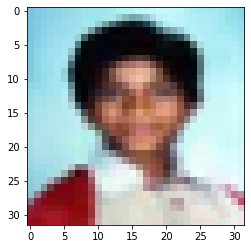

In [4]:
plt.imshow(X[3])
print(y[3])
X[3].shape
print((X[3].dtype))

In [5]:
def show_reconstructions(model, images, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        
def plot_image(image):
    plt.imshow(image)
    plt.axis("off")

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.20, random_state=66)

In [7]:
print(y_val.shape)
print(X_train.shape)

(1000, 1)
(4000, 32, 32, 3)


In [8]:
X_train = X_train.astype('float32') / 255.
X_val = X_val.astype('float32') / 255.

In [9]:
## With a Neural Network

import tensorflow as tf
from tensorflow import keras

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

'''model = keras.models.Sequential([
    DefaultConv2D(filters=32, kernel_size=3, input_shape=[32,32, 3]),
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="softmax")
])'''

encoder = keras.models.Sequential([
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="relu", input_shape=[32, 32, 3]),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2)
])
encoder.summary()

decoder = keras.models.Sequential([
    keras.layers.UpSampling2D((2,2), input_shape = [4,4,64]),
    keras.layers.Conv2DTranspose(32, kernel_size=3, padding="SAME", activation="relu"),
    keras.layers.UpSampling2D((2,2)),
    keras.layers.Conv2DTranspose(16, kernel_size=3,  padding="SAME", activation="relu"),
    keras.layers.UpSampling2D((2,2)),
    keras.layers.Conv2DTranspose(3, kernel_size=3, padding="SAME", activation="sigmoid"),
])
decoder.summary()
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
Total params: 23,584
Trainable params: 23,584
Non-trainable params: 0
____________________________________________________

In [10]:
autoencoder.compile(loss='mean_squared_error', optimizer = 'RMSprop')

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_model.h5", save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb]


autoencoder.fit(X_train, y_train, epochs=100, batch_size = 64,
          validation_data=(X_val, y_val))

#callbacks=callbacks

Epoch 1/100


InvalidArgumentError:  Incompatible shapes: [64,1] vs. [64,32,32,3]
	 [[node mean_squared_error/SquaredDifference (defined at <ipython-input-10-c3850684e476>:9) ]] [Op:__inference_train_function_1415]

Function call stack:
train_function


In [27]:
autoencoder.save_weights('autoencoder.h5')

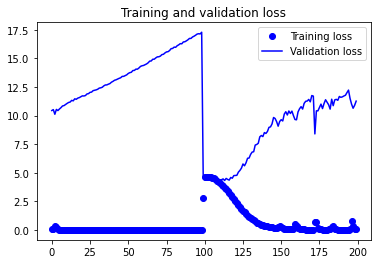

In [26]:
loss = np.array(autoencoder.history.history['loss'])
val_loss = np.array(autoencoder.history.history['val_loss'])
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [11]:
def fully_connected(ac):
    ac.add(keras.layers.Flatten())
    ac.add(keras.layers.Dense(128, activation='relu'))
    ac.add(keras.layers.Dense(100, activation='softmax'))
    return ac

full_model = fully_connected(encoder)

'''for layer in full_model.layers[0:len(encoder.layers)]:
    layer.trainable = False'''
    

full_model.compile(loss="sparse_categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])

'''early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_model.h5", save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb]'''


full_model.fit(X_train, y_train, epochs=100,
          validation_data=(X_val, y_val))


full_model.save_weights('autoencoder_classification.h5')

Epoch 1/100
125/125 [==============================] - 1s 4ms/step - loss: 4.5558 - accuracy: 0.0195 - val_loss: 4.4296 - val_accuracy: 0.0360
Epoch 2/100
125/125 [==============================] - 0s 3ms/step - loss: 4.2927 - accuracy: 0.0415 - val_loss: 4.2539 - val_accuracy: 0.0450
Epoch 3/100
125/125 [==============================] - 0s 3ms/step - loss: 4.0584 - accuracy: 0.0685 - val_loss: 4.1127 - val_accuracy: 0.0800
Epoch 4/100
125/125 [==============================] - 0s 3ms/step - loss: 3.8370 - accuracy: 0.0990 - val_loss: 3.9710 - val_accuracy: 0.1010
Epoch 5/100
125/125 [==============================] - 0s 3ms/step - loss: 3.5974 - accuracy: 0.1370 - val_loss: 3.8579 - val_accuracy: 0.1170
Epoch 6/100
125/125 [==============================] - 0s 4ms/step - loss: 3.3624 - accuracy: 0.1710 - val_loss: 3.7812 - val_accuracy: 0.1240
Epoch 7/100
125/125 [==============================] - 0s 3ms/step - loss: 3.1245 - accuracy: 0.2218 - val_loss: 3.7605 - val_accuracy: 0.1460

125/125 [==============================] - 0s 3ms/step - loss: 4.2124e-04 - accuracy: 1.0000 - val_loss: 13.6727 - val_accuracy: 0.1650
Epoch 58/100
125/125 [==============================] - 0s 3ms/step - loss: 3.9339e-04 - accuracy: 1.0000 - val_loss: 13.7586 - val_accuracy: 0.1640
Epoch 59/100
125/125 [==============================] - 0s 3ms/step - loss: 3.6541e-04 - accuracy: 1.0000 - val_loss: 13.8437 - val_accuracy: 0.1640
Epoch 60/100
125/125 [==============================] - 0s 3ms/step - loss: 3.5861e-04 - accuracy: 1.0000 - val_loss: 13.9238 - val_accuracy: 0.1640
Epoch 61/100
125/125 [==============================] - 0s 3ms/step - loss: 3.2684e-04 - accuracy: 1.0000 - val_loss: 13.9938 - val_accuracy: 0.1650
Epoch 62/100
125/125 [==============================] - 0s 3ms/step - loss: 2.9587e-04 - accuracy: 1.0000 - val_loss: 14.0901 - val_accuracy: 0.1640
Epoch 63/100
125/125 [==============================] - 1s 4ms/step - loss: 2.7827e-04 - accuracy: 1.0000 - val_loss: 1

In [12]:
'''for layer in full_model.layers[0:len(encoder.layers)]:
    layer.trainable = True'''
    
full_model.compile(loss="sparse_categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])

train = full_model.fit(X_train, y_train, epochs=100,
          validation_data=(X_val, y_val))

full_model.save_weights('classification_complete.h5')

Epoch 1/100
125/125 [==============================] - 1s 4ms/step - loss: 0.1205 - accuracy: 0.9620 - val_loss: 14.1860 - val_accuracy: 0.1510
Epoch 2/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0855 - accuracy: 0.9720 - val_loss: 13.9267 - val_accuracy: 0.1600
Epoch 3/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0590 - accuracy: 0.9837 - val_loss: 13.9621 - val_accuracy: 0.1570
Epoch 4/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0462 - accuracy: 0.9870 - val_loss: 14.0358 - val_accuracy: 0.1560
Epoch 5/100
125/125 [==============================] - 0s 3ms/step - loss: 0.1142 - accuracy: 0.9610 - val_loss: 13.2969 - val_accuracy: 0.1620
Epoch 6/100
125/125 [==============================] - 0s 3ms/step - loss: 0.1136 - accuracy: 0.9665 - val_loss: 13.0271 - val_accuracy: 0.1400
Epoch 7/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0695 - accuracy: 0.9778 - val_loss: 13.2864 - val_accuracy:

125/125 [==============================] - 0s 3ms/step - loss: 0.0319 - accuracy: 0.9930 - val_loss: 14.9242 - val_accuracy: 0.1500
Epoch 58/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0310 - accuracy: 0.9902 - val_loss: 15.0864 - val_accuracy: 0.1460
Epoch 59/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0363 - accuracy: 0.9880 - val_loss: 15.9202 - val_accuracy: 0.1420
Epoch 60/100
125/125 [==============================] - 0s 3ms/step - loss: 0.1803 - accuracy: 0.9450 - val_loss: 14.3285 - val_accuracy: 0.1450
Epoch 61/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0805 - accuracy: 0.9737 - val_loss: 14.9999 - val_accuracy: 0.1570
Epoch 62/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0799 - accuracy: 0.9743 - val_loss: 15.2011 - val_accuracy: 0.1480
Epoch 63/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0555 - accuracy: 0.9835 - val_loss: 14.8911 - val_accuracy: 0.158

In [14]:
accuracy = train.history['accuracy']
val_accuracy = train.history['val_accuracy']
loss = train.history['loss']
val_loss = train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

KeyError: 'val_acc'

In [12]:
y_pred = full_model.predict(X_test)
y_pred = [np.argmax(y) for y in y_pred ]
df = pd.DataFrame(y_pred)
df.columns =['label']
df.index.name = 'index'
df.to_csv('y_output.csv')